In [1]:
# import base class for the manipulation of a SITELLE spectral cube: SpectralCube
from orcs.process import SpectralCube
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np

In [2]:
# load out data cube
cube = SpectralCube('2912251z.hdf5')

INFO:root:CFHT version
INFO:root:Cube is level 2.5
INFO:root:shape: (2048, 2064, 113)
INFO:root:wavenumber calibration: True
INFO:root:flux calibration: True
INFO:root:wcs calibration: True


Text(0.5, 1.0, 'counts')

<Figure size 1440x1440 with 0 Axes>

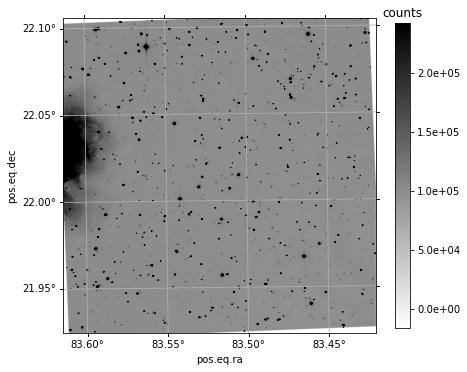

In [3]:
# explore the deep frame (in counts)
plt.figure(figsize=(20,20))
deep = cube.get_deep_frame() # this step should take a second or less. If it takes a lot of time, see above.
deep.imshow(perc=98.5, cmap='gray_r',wcs=True)
plt.grid()
cb = pl.colorbar(shrink=0.8, format='%.1e')
cb.ax.set_title('counts')
#deep.to_fits('2912251z_c3_filter.fits') # if you want to exampine it your way (e.g. with ds9 :P)
#plt.savefig('crab_at_c3_filter_part1.jpeg')

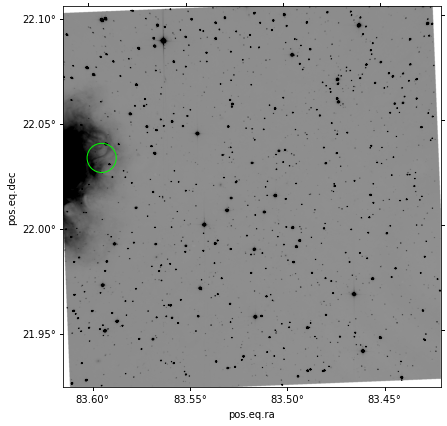

In [4]:
import pyregion

# draw the background image
deep.imshow(cmap='gray_r', perc=98.5,wcs=True)

# load region file and draw the regions
reg = pyregion.open('test.reg').as_imagecoord(cube.get_wcs_header())

ax = pl.gca()
patch_list, artist_list = reg.get_mpl_patches_texts()
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)

In [5]:
#calculate the SNR using the center of the region selected as reference with 20 pixels of radius
def SNR(x,y,r):
    spectrum = cube.get_spectrum(x, y, r)
    background = cube.get_spectrum_in_annulus(x, y, r, 25, median=True, mean_flux=True)
    spectrum_corr = spectrum.subtract_sky(background)
    wavelength = (1/spectrum_corr.axis.data)*pow(10,8)
    signal = np.nanmax(spectrum_corr.data[50:60])
    noise = np.nanstd(spectrum_corr.data[24:79])
    snr = round(abs(signal/noise),2)
    print('SNR for this point is: {}'.format(snr))

SNR(206, 1239,20)

SNR for this point is: 2.11


Text(0, 0.5, 'Flux x 10$^{-15}$ [ergs cm$^{-2}$ s$^{-1}$] ')

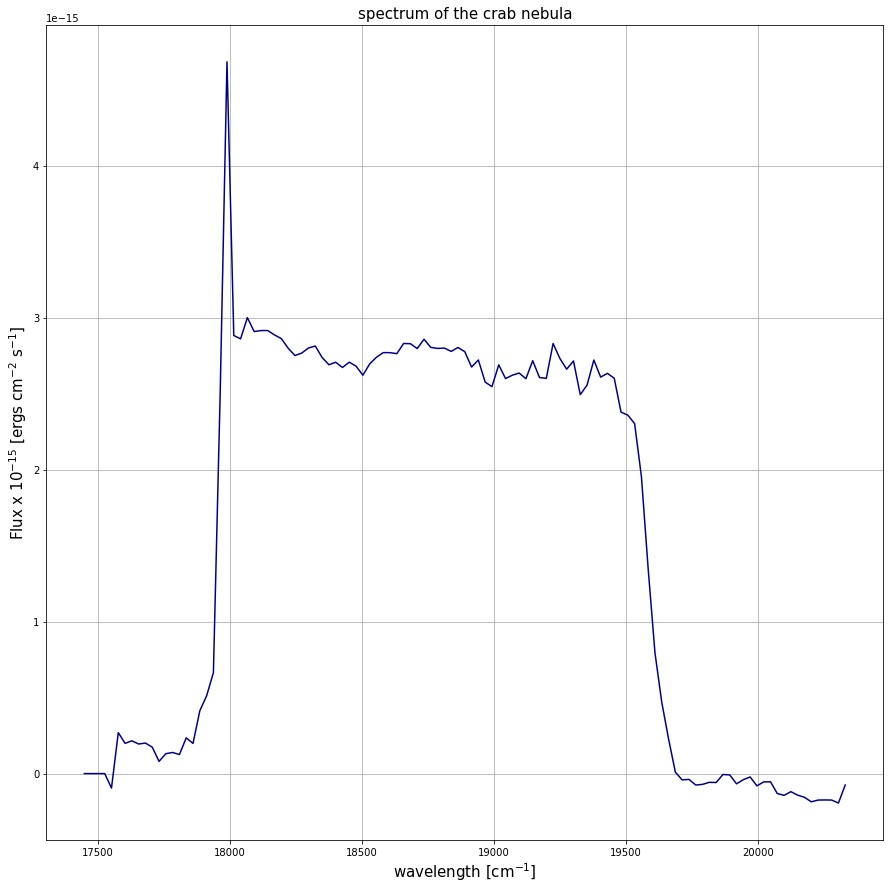

In [6]:
# extract and plot a spectrum for the region
plt.figure(figsize=(15,15))
spectrum = cube.get_spectrum(206, 1239,20) # option mean_flux
spectrum.plot(plot_real=True,color='darkblue')
pl.grid()
pl.title('spectrum of the crab nebula',size=15)
pl.xlabel('wavelength [cm$^{-1}$]',size=15)
pl.ylabel('Flux x 10$^{-15}$ [ergs cm$^{-2}$ s$^{-1}$] ',size=15)

Text(0.5, 1.0, 'Background around the crab nebula')

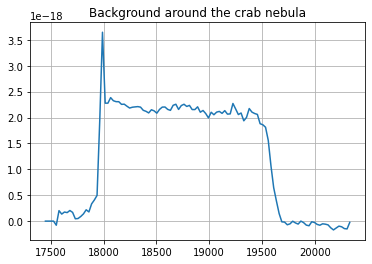

In [7]:
# get the sky spectrum
background = cube.get_spectrum_in_annulus(206, 1239, 20, 25, median=True, mean_flux=True)
# mean_flux=True: The mean flux is returned (i.e. integrated flux / number of integrated pixels).
#  This is important when computing a sky spectrum.
#
# median=True: When combining spectra, the median is used instead of the mean (if mean_flux is True,
#  the computed median vector is then multiplied by the number of integrated pixels to keep with a
#  measure of the total flux.). On large integrated regions, this operation removes outliers like
#  isolated bright stars.
background.plot()
pl.grid()
pl.title('Background around the crab nebula')

Text(0, 0.5, 'Flux x 10$^{-15}$ [ergs cm$^{-2}$ s$^{-1}$] ')

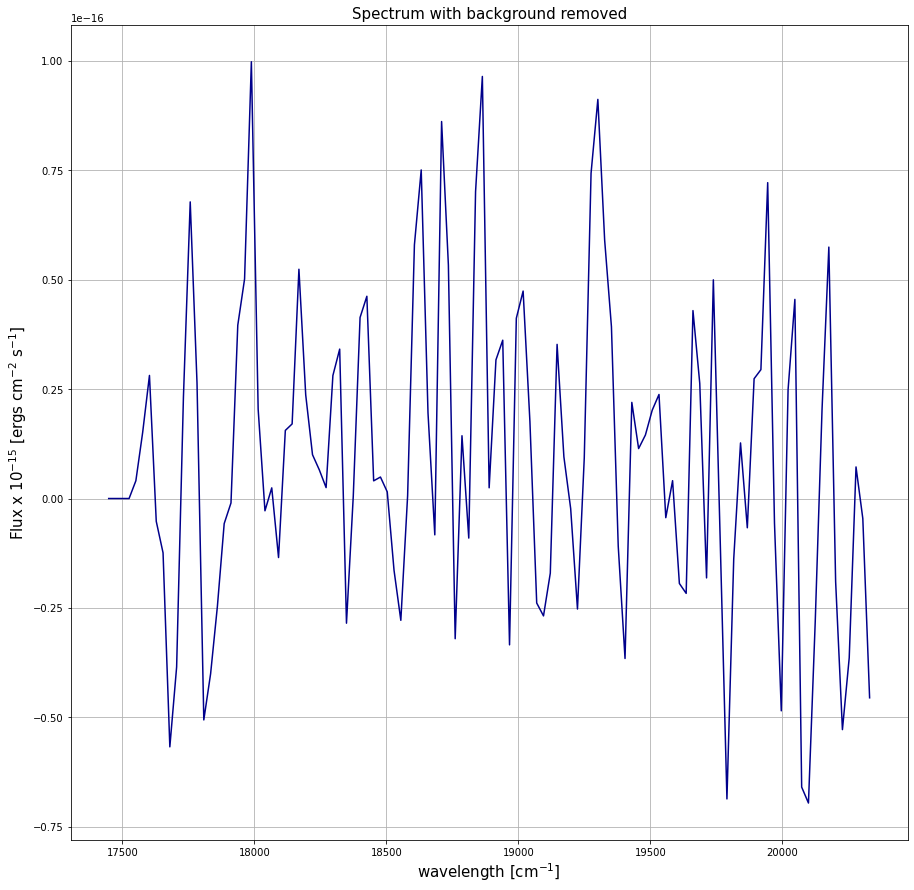

In [8]:
# Background is high below the source. It can be removed by subtracting the spectrum of a region in a an annulus around the source.
plt.figure(figsize=(15,15))
spectrum_corr = spectrum.subtract_sky(background)
# note that you didn't have to bother with the number of integrated pixels in each spectrum
# (even if both have been integrated over different surfaces)
spectrum_corr.plot(color='darkblue')
pl.grid()
pl.title('Spectrum with background removed',size=15)
#pl.title('spectrum of the crab nebula',size=15)
pl.xlabel('wavelength [cm$^{-1}$]',size=15)
pl.ylabel('Flux x 10$^{-15}$ [ergs cm$^{-2}$ s$^{-1}$] ',size=15)

/home/lucas/anaconda3/envs/orb3_fixed/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


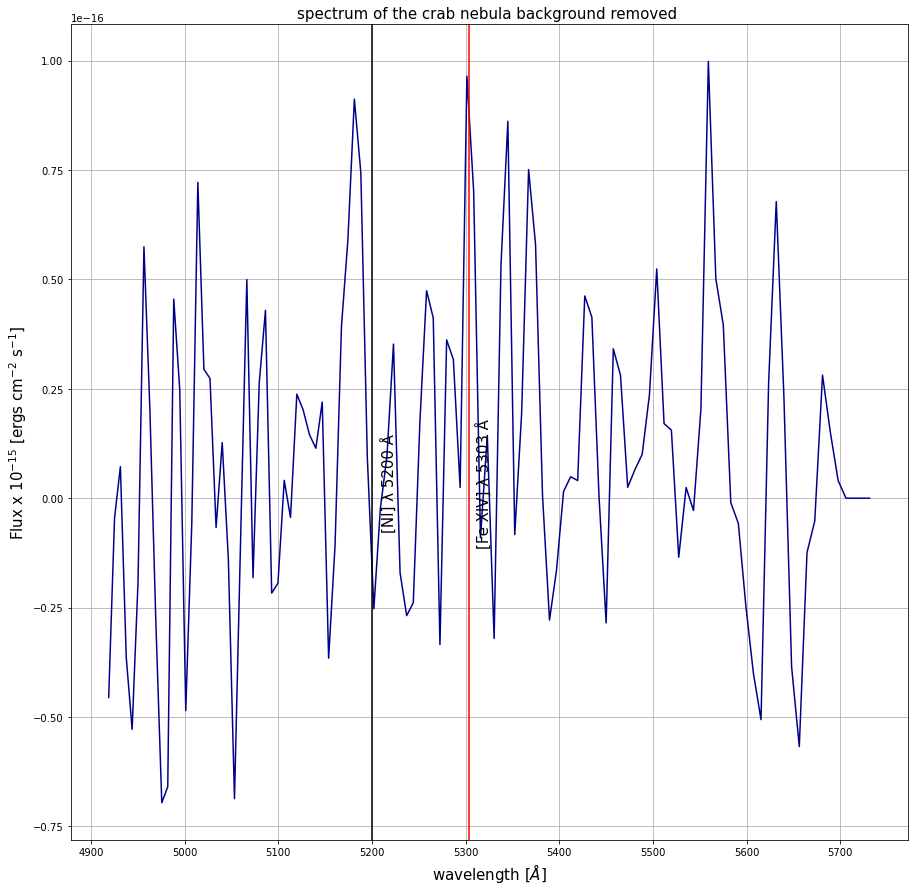

In [9]:
# in wavelength
plt.figure(figsize=(15,15))
wavelength = (1/spectrum_corr.axis.data)*pow(10,8)
plt.plot(wavelength,spectrum_corr.data,color='darkblue')
pl.grid()
pl.title('spectrum of the crab nebula background removed ',size=15)
pl.xlabel('wavelength [$\AA$]',size=15)
pl.ylabel('Flux x 10$^{-15}$ [ergs cm$^{-2}$ s$^{-1}$] ',size=15)
plt.axvline(x = 5303, color = 'red', label = 'axvline - full height')
plt.text(5312, 0.35*10**(-17), '[Fe XIV] \u03BB 5303 \u212B', rotation=90, va='center', fontsize = 15)
plt.axvline(x = 5200, color = 'black', label = 'axvline - full height')
plt.text(5210, 0.35*10**(-17), '[NI] \u03BB 5200 \u212B', rotation=90, va='center', fontsize = 15)
#plt.savefig('crab_at_n2_filter_specbackground_rem_x1385y1016.jpeg')
plt.show()

In [10]:
# Compute the channel width (in cm-1)
# you can simply get it from the axis of the cube (which is in cm-1)
print('channel width (cm-1)', cube.params.base_axis[1] - cube.params.base_axis[0])

channel width (cm-1) 25.734664264113235


In [11]:
# you can relate the channel size to the line width as the FWHM of a sinc line is equal to 1.20671 x width 
# and the width of a sinc line is equal to 1.25 the channel size by construction (because there are 25% more 
# steps made than necessary on the left size of the ZPD to be able to compute the phase)
# the number of steps really contributing to the resolution are the steps made at the right of the ZPD which can be
# esaily calculated
print('line width (cm-1)', cube.params.line_fwhm / 1.20671)
print('number of steps at the right of ZPD (contributing to the resolution)', cube.params.step_nb - cube.params.zpd_index)
print('ratio of the step number / the number of steps at the right of the ZPD', cube.params.step_nb / float(cube.params.step_nb - cube.params.zpd_index))
print('channel width (cm-1)', cube.params.line_fwhm / 1.20671 / 1.25)

line width (cm-1) 32.31130068716392
number of steps at the right of ZPD (contributing to the resolution) 90
ratio of the step number / the number of steps at the right of the ZPD 1.2555555555555555
channel width (cm-1) 25.849040549731136


In [12]:
# Finally, you can relate the line width with the resolution at the mean wavenumber of the cube 
# and then compute the channel size
print('Spectral resolution: ', cube.params.resolution)
mean_cm1 = (cube.params.base_axis[-1] + cube.params.base_axis[0]) / 2
print('Mean wavenumber', mean_cm1)
line_fwhm = mean_cm1 / cube.params.resolution 
print('Line width (cm-1)',  line_fwhm)
print('channel width (cm-1)', line_fwhm / 1.20671 / 1.25)

Spectral resolution:  484.7892202766199
Mean wavenumber 18889.243569858838
Line width (cm-1) 38.96382753535788
channel width (cm-1) 25.831444198097557


In [13]:
import orb.utils.spectrum
channel_width = cube.params.base_axis[1] - cube.params.base_axis[0]
mean_cm1 = (cube.params.base_axis[-1] + cube.params.base_axis[0]) / 2
print('channel width in km/s at the mean wavenumber of the axis', orb.utils.spectrum.compute_radial_velocity(mean_cm1 + channel_width, mean_cm1, wavenumber=True))

channel width in km/s at the mean wavenumber of the axis -408.1583649777252


In [14]:
# it could be directly computed with the following formula
c = 3e5 # lightspeed in km/s
print('channel width in km/s at the mean wavenumber of the axis', c * channel_width / mean_cm1)

channel width in km/s at the mean wavenumber of the axis 408.7193460490523


velocity estimate (km/s) [nan]
fluxes estimate (erg/cm^2/s) [[nan, nan]]


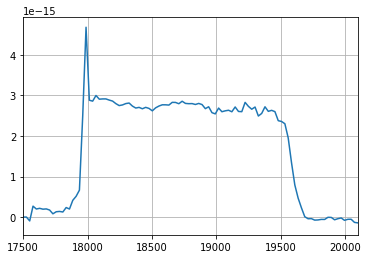

In [15]:
spectrum = cube.get_spectrum(206, 1239, 20)

#all the spectrum
spectrum.plot()
pl.xlim((17500,20100))
pl.grid()

vel, fluxes = spectrum.estimate_parameters(('[NI]5200', '[FeXIV]5303'), [-408, 408])
print('velocity estimate (km/s)', vel)
print('fluxes estimate (erg/cm^2/s)', fluxes)

In [16]:
cube.params.resolution

484.7892202766199

In [17]:
estimates = cube.estimate_parameters_in_region('test.reg', ('[NI]5200', '[FeXIV]5303'), [-408, 408],
                                               binning=1)

INFO:root:Init of the parallel processing server with 8 threads
INFO:root:passed mapped kwargs : []
INFO:root:159 rows to fit


 [==========] [100%] [completed in 1m16s]                                     

INFO:root:Closing parallel processing server


INFO:root:Data written as ./Crab_FS01_C3/Crab_FS01_C3.SpectralCube.estimated_velocity.0.fits in 0.13 s 
INFO:root:Data written as ./Crab_FS01_C3/Crab_FS01_C3.SpectralCube.estimated_score.0.fits in 0.12 s 
INFO:root:Data written as ./Crab_FS01_C3/Crab_FS01_C3.SpectralCube.estimated_NI5200.0.fits in 0.12 s 
INFO:root:Data written as ./Crab_FS01_C3/Crab_FS01_C3.SpectralCube.estimated_FeXIV5303.0.fits in 0.12 s 


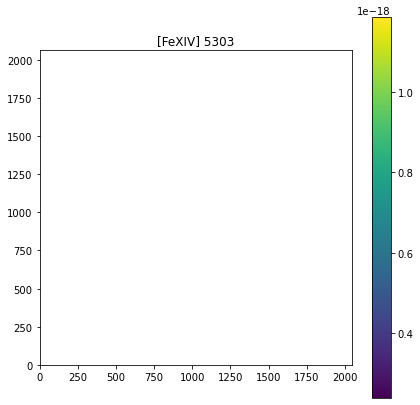

In [18]:
import orb.utils.graph as graph
vel_map = orb.utils.io.read_fits('/home/lucas/orcs-stable/orcs/sitelle_crab_2024/Crab_FS01_C3/Crab_FS01_C3.SpectralCube.estimated_FeXIV5303.0.fits')
graph.imshow(vel_map)
#pl.xlim((1,1000))
#pl.ylim((300,1800))
pl.title('[FeXIV] 5303')
pl.colorbar()

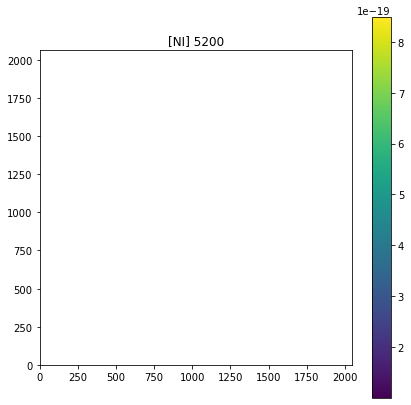

In [19]:
import orb.utils.graph as graph
vel_map = orb.utils.io.read_fits('/home/lucas/orcs-stable/orcs/sitelle_crab_2024/Crab_FS01_C3/Crab_FS01_C3.SpectralCube.estimated_NI5200.0.fits')
graph.imshow(vel_map)
#pl.xlim((1,1000))
#pl.ylim((300,1800))
pl.title('[NI] 5200')
pl.colorbar()